In [3]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from itertools import product
import warnings
warnings.filterwarnings('ignore')
import Data_Process as dp
from sklearn.model_selection import train_test_split
import Model_LSTM as mlstm

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import Constants





In [96]:
info = pd.read_csv("g-research-crypto-forecasting/asset_details.csv")
ctrain = pd.read_csv("g-research-crypto-forecasting/train.csv").set_index("timestamp")

In [5]:
DEBUG = Constants.DEBUG
EPOCHS = Constants.EPOCHS
N_ASSETS = Constants.N_ASSETS
WINDOW_SIZE = Constants.WINDOW_SIZE
BATCH_SIZE = Constants.BATCH_SIZE
PCT_VALIDATION = Constants.PCT_VALIDATION # last 10% of the data are used as validation set

In [97]:
#train mini data
n_steps_to_train = 360*24*60-8 #0.5 year
ctrain_mini =  ctrain[-n_steps_to_train:]

In [108]:
ctrain_processed = dp.process_all_assets(ctrain_mini)



In [109]:
ctrain_processed



,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Spread,Close_Open,Upper_Shadow,Lower_Shadow,spread,mean_trade,log_price_change,group_num,is_real,asset_order
timestamp,,,,,,,,,,,,,,,,,,,
1629960420,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0
1629960420,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1
1629960420,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,2
1629960420,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,3
1629960420,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632182400,9,1.172996,0.125762,0.125546,0.125280,0.125377,0.025982,0.125452,0.0,0.269004,-4.142758,0.017946,0.428209,0.269004,0.000968,-1.523890,37032,1,9
1632182400,10,-0.390295,3.684814,3.683682,3.676962,3.678302,-0.010902,3.681353,0.0,6.069084,-72.462364,2.101668,6.206818,6.069084,-0.012215,-1.719258,37032,1,10
1632182400,13,0.339662,-0.119467,-0.119632,-0.119373,-0.119480,17.353397,-0.119489,0.0,-0.172423,-0.000728,-0.146320,-0.149883,-0.172423,12.884546,-0.460071,37032,1,11


In [110]:
ctrain_processed2_mini_scaled =ctrain_processed.copy()


In [112]:
#reshape for model

targets = ctrain_processed2_mini_scaled['Target'].to_numpy().reshape(-1, N_ASSETS)
features = ctrain_processed2_mini_scaled.columns.drop(['Asset_ID', 'Target', 'group_num','is_real'])
train = ctrain_processed2_mini_scaled[features]
train_data = ctrain_processed2_mini_scaled.values.reshape(-1, N_ASSETS, ctrain_processed2_mini_scaled.shape[1])




In [113]:
X_train, X_test = train_data[:-len(train_data)//PCT_VALIDATION], train_data[-len(train_data)//PCT_VALIDATION:]
y_train, y_test = targets[:-len(train_data)//PCT_VALIDATION], targets[-len(train_data)//PCT_VALIDATION:]

In [114]:
train_generator = mlstm.sample_generator(X_train, y_train, length=WINDOW_SIZE, batch_size=BATCH_SIZE)
val_generator = mlstm.sample_generator(X_test, y_test, length=WINDOW_SIZE, batch_size=BATCH_SIZE)
print(f'Sample shape: {train_generator[0][0].shape}')
print(f'Target shape: {train_generator[0][1].shape}')

Sample shape: (1024, 15, 14, 19)
Target shape: (1024, 14)


In [115]:
model = mlstm.get_modell(X_train, y_train)
model.summary()



Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 15, 14, 19)] 0                                            
__________________________________________________________________________________________________
lambda_71 (Lambda)              (None, 15, 19)       0           input_7[0][0]                    
__________________________________________________________________________________________________
lambda_72 (Lambda)              (None, 15, 19)       0           input_7[0][0]                    
__________________________________________________________________________________________________
lambda_73 (Lambda)              (None, 15, 19)       0           input_7[0][0]                    
____________________________________________________________________________________________

In [116]:
tf.keras.utils.plot_model(mlstm.get_modell(X_train, y_train,n_assets=1), show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [117]:
tf.random.set_seed(0)
estop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='min', restore_best_weights=True)
scheduler = keras.optimizers.schedules.ExponentialDecay(1e-3, (0.5 * len(X_train) / BATCH_SIZE), 1e-3)
lr = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

In [118]:
history = model.fit(train_generator, validation_data=(val_generator), epochs=EPOCHS, callbacks=[lr, estop])

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
33/33 [==============================] - 62s 644ms/step - loss: 0.0388 - Correlation: 0.0183 - val_loss: 0.0013 - val_Correlation: 0.0072

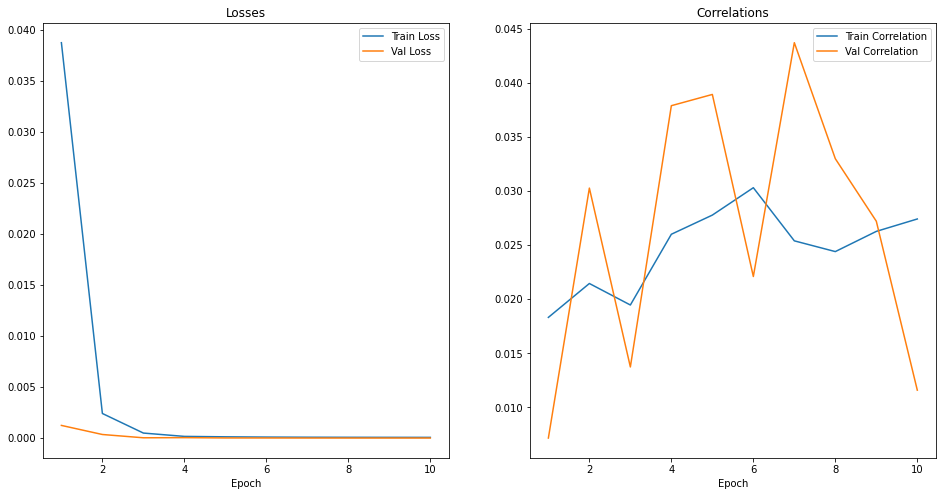

In [119]:
mlstm.plot_training_history(history)

In [120]:
predictions = model.predict(val_generator)

Asset:    Corr. coef.
---------------------
Binance Coin: nan


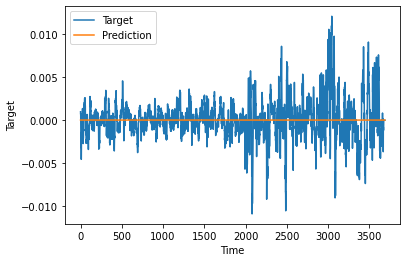

Bitcoin: nan


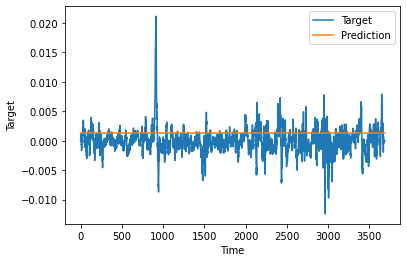

Bitcoin Cash: nan


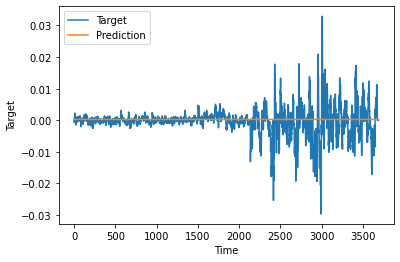

Cardano: nan


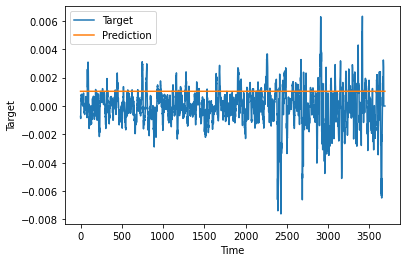

Dogecoin: nan


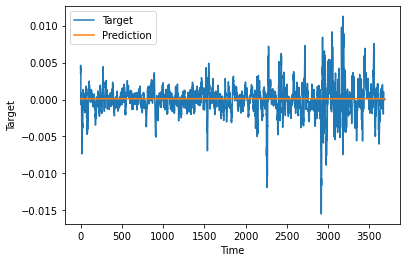

EOS.IO: nan


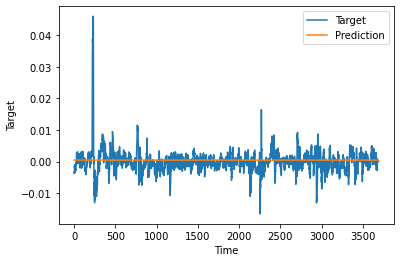

Ethereum: nan


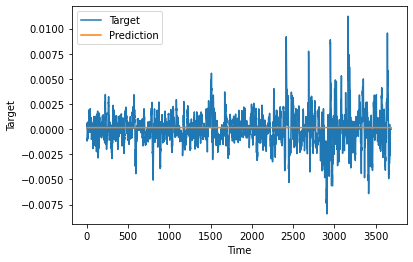

Ethereum Classic: nan


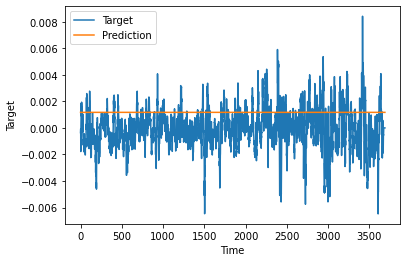

IOTA: nan


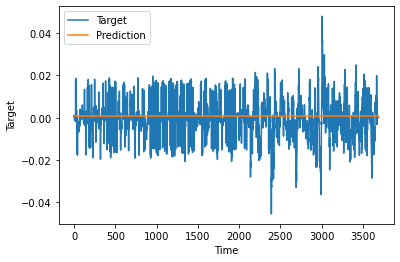

Litecoin: nan


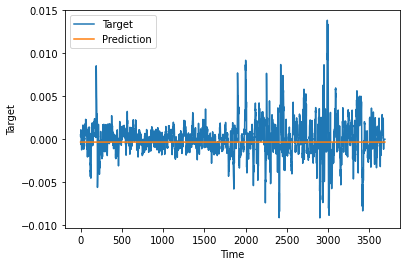

Maker: nan


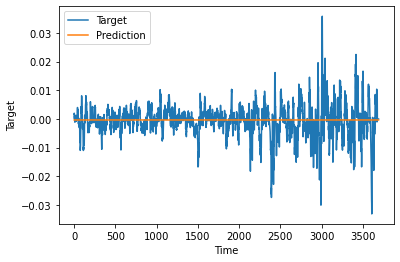

Monero: nan


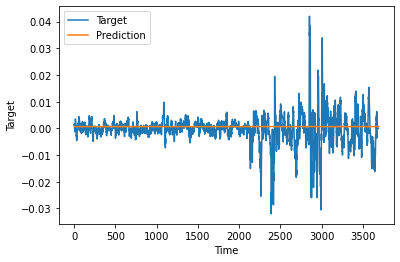

Stellar: nan


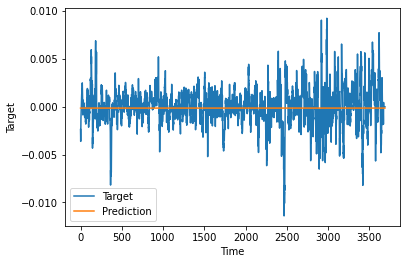

TRON: nan


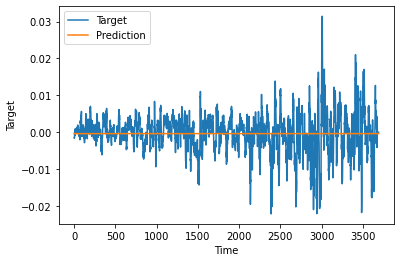

In [121]:
perf_df = mlstm.prediction_details(predictions=predictions, y_test=y_test, asset_details=info, model_name='1 layer LSTM',assets=range(N_ASSETS))


perf_df = perf_df.append([pd.Series(['1 layer LSTM', 'WEIGhTED', (perf_df['corr']*perf_df['weights']).sum(), 1 ],index = perf_df.columns)], ignore_index=True)
perf_df.to_csv('Performance1layerLSTM.csv')

In [122]:
perf_df

,Model,asset,corr,weights
0,1 layer LSTM,Binance Coin,NaN,4.304065
1,1 layer LSTM,Bitcoin,NaN,6.779922
2,1 layer LSTM,Bitcoin Cash,NaN,2.397895
3,1 layer LSTM,Cardano,NaN,4.406719
4,1 layer LSTM,Dogecoin,NaN,3.555348
5,1 layer LSTM,EOS.IO,NaN,1.386294
6,1 layer LSTM,Ethereum,NaN,5.894403
7,1 layer LSTM,Ethereum Classic,NaN,2.079442
8,1 layer LSTM,IOTA,NaN,1.098612
9,1 layer LSTM,Litecoin,NaN,2.397895


Multivariate 2-Layered Bidirectional LSTM

In [46]:
model_Bidirectional_2_layer = mlstm.get_model_Bidirectional_2_layer(X_train, y_train)
model_Bidirectional_2_layer.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 15, 14, 12)] 0                                            
__________________________________________________________________________________________________
lambda_15 (Lambda)              (None, 15, 12)       0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_16 (Lambda)              (None, 15, 12)       0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, 15, 12)       0           input_3[0][0]                    
____________________________________________________________________________________________

In [47]:
history_Bidirectional_2_layer = model_Bidirectional_2_layer.fit(train_generator, validation_data=(val_generator), epochs=EPOCHS, callbacks=[lr, estop])



Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
33/33 [==============================] - 258s 3s/step - loss: 2.1046 - Correlation: 0.0959 - val_loss: 2.2742 - val_Correlation: 0.2352

In [48]:
predictions_Bidirectional_2_layer = model_Bidirectional_2_layer.predict(val_generator)

Asset:    Corr. coef.
---------------------
Binance Coin: -0.3603


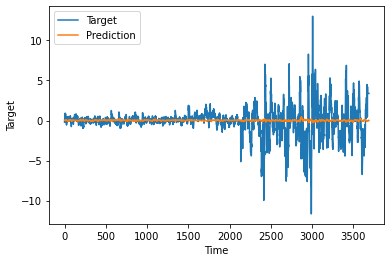

Bitcoin: 0.0290


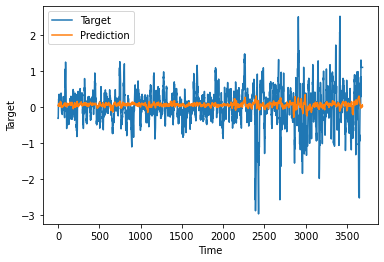

Bitcoin Cash: 0.1954


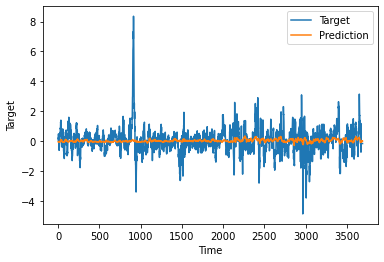

Cardano: -0.2094


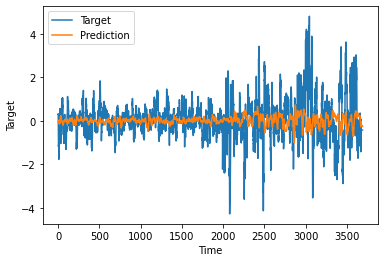

Dogecoin: -0.1588


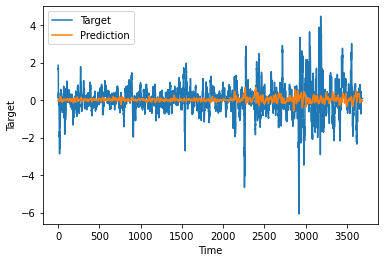

EOS.IO: 0.0791


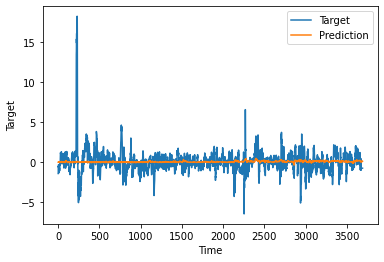

Ethereum: 0.1238


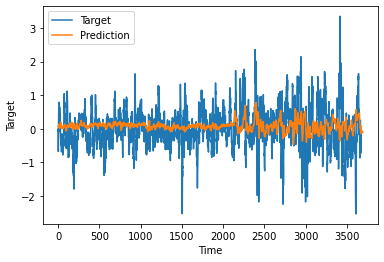

Ethereum Classic: -0.0091


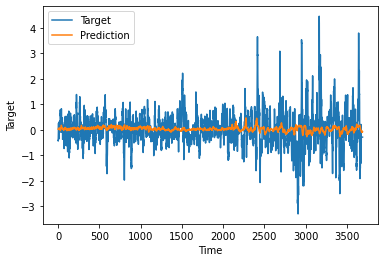

IOTA: 0.3784


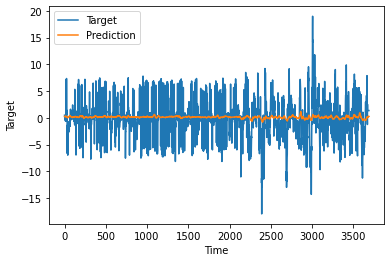

Litecoin: 0.1442


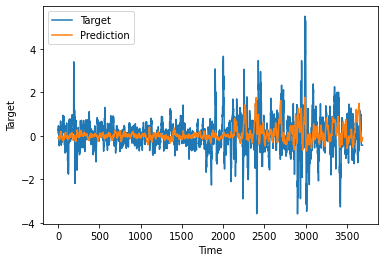

Maker: 0.4285


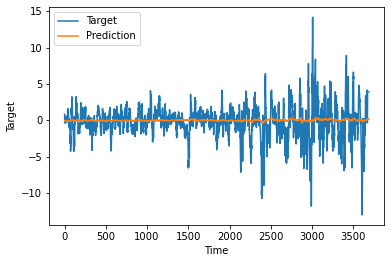

Monero: 0.4978


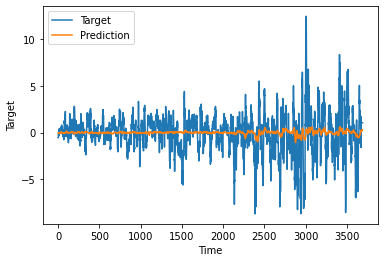

Stellar: -0.0138


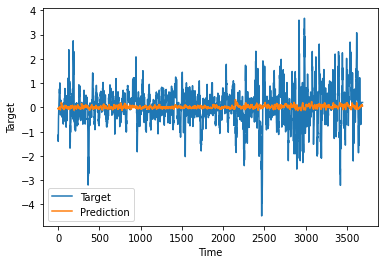

TRON: 0.9098


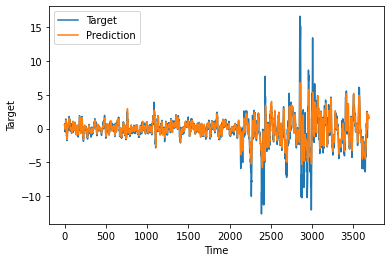

In [49]:
perf_df_2_layer = mlstm.prediction_details(predictions=predictions_Bidirectional_2_layer, y_test=y_test, asset_details=info, assets=range(N_ASSETS))

In [68]:
perf_df_2_layer = perf_df_2_layer.append([pd.Series(['Bidirectional_2_layer', 'WEIGHTED', (perf_df_2_layer['corr']*perf_df_2_layer['weights']).sum(), 1 ],index = perf_df_2_layer.columns)], ignore_index=True)

perf_df_2_layer.to_csv('Performanceidirectional_2_layers_LSTM.csv')

perf_df_2_layer

,Model,asset,corr,weights
0,LSTM_2layer,Binance Coin,-0.360338,4.304065
1,LSTM_2layer,Bitcoin,0.029028,6.779922
2,LSTM_2layer,Bitcoin Cash,0.195353,2.397895
3,LSTM_2layer,Cardano,-0.209396,4.406719
4,LSTM_2layer,Dogecoin,-0.158802,3.555348
5,LSTM_2layer,EOS.IO,0.079127,1.386294
6,LSTM_2layer,Ethereum,0.123752,5.894403
7,LSTM_2layer,Ethereum Classic,-0.009051,2.079442
8,LSTM_2layer,IOTA,0.378399,1.098612
9,LSTM_2layer,Litecoin,0.144166,2.397895


2 LSTM

In [125]:
model_2lstm = mlstm.get_model_2lstm(X_train, y_train)

Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
33/33 [==============================] - 107s 1s/step - loss: -0.0040 - Correlation: 0.0431 - val_loss: 0.0327 - val_Correlation: 0.0306

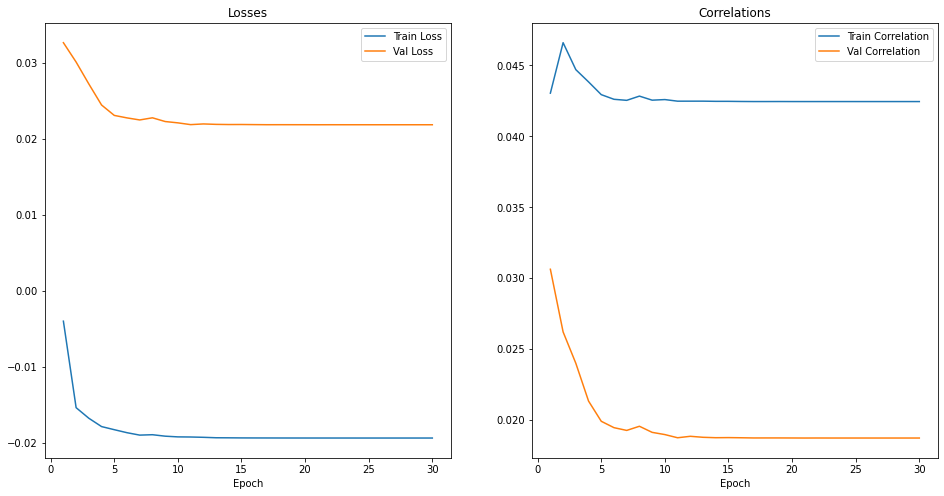

In [126]:
history_model_2lstm = model_2lstm.fit(train_generator, validation_data=(val_generator), epochs=30, callbacks=[lr])

mlstm.plot_training_history(history_model_2lstm)


In [127]:
predictions_model_2lstm = model_2lstm.predict(val_generator)

Asset:    Corr. coef.
---------------------
Binance Coin: -0.1106


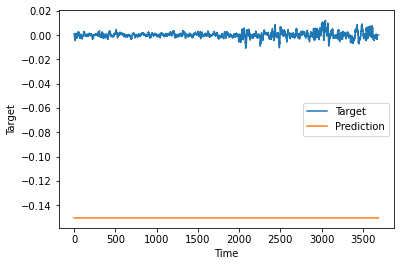

Bitcoin: -0.0086


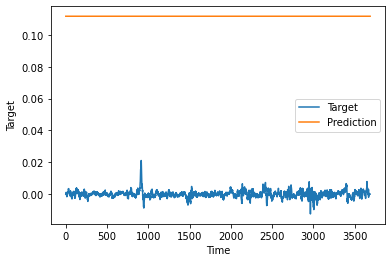

Bitcoin Cash: -0.0261


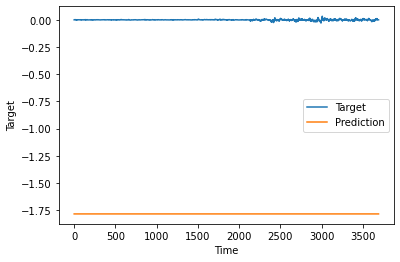

Cardano: 0.0138


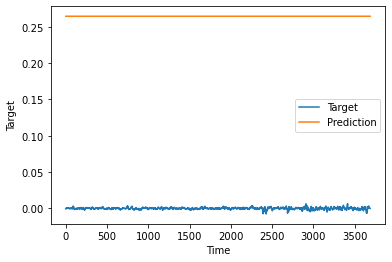

Dogecoin: -0.0261


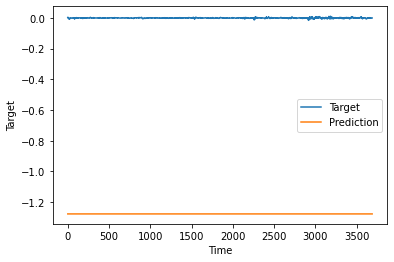

EOS.IO: -0.0041


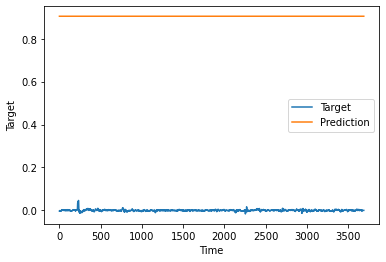

Ethereum: 0.0721


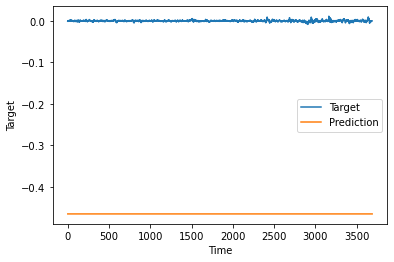

Ethereum Classic: nan


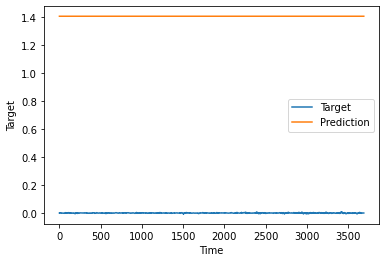

IOTA: 0.0111


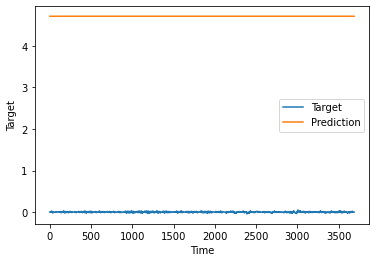

Litecoin: -0.0342


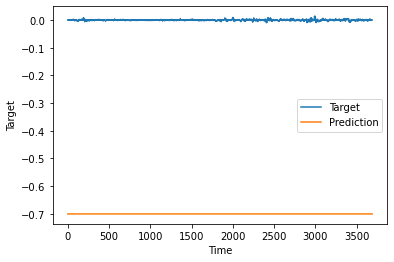

Maker: -0.0093


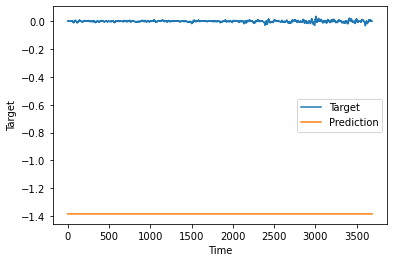

Monero: 0.0182


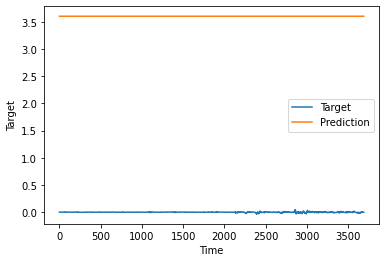

Stellar: 0.0283


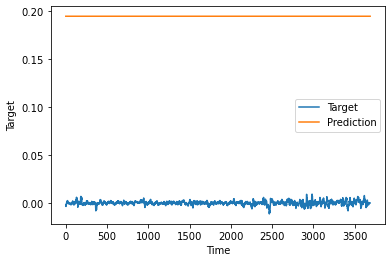

TRON: 0.0104


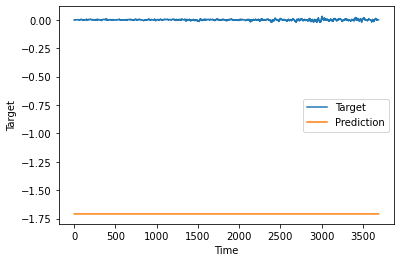

In [128]:
perf_df_model_2lstm = mlstm.prediction_details(predictions=predictions_model_2lstm,
                                           y_test=y_test, asset_details=info,model_name ='LSTM_2layer',assets=range(N_ASSETS))

In [129]:
perf_df_model_2lstm = perf_df_model_2lstm.append([pd.Series(['LSTM_2_layers', 'WEIGHTED', (perf_df_model_2lstm['corr']*perf_df_model_2lstm['weights']).sum(), 1 ],index = perf_df_model_2lstm.columns)], ignore_index=True)

perf_df_model_2lstm.to_csv('Performance_2_layers_LSTM.csv')

perf_df_model_2lstm

,Model,asset,corr,weights
0,LSTM_2layer,Binance Coin,-0.110600,4.304065
1,LSTM_2layer,Bitcoin,-0.008636,6.779922
2,LSTM_2layer,Bitcoin Cash,-0.026083,2.397895
3,LSTM_2layer,Cardano,0.013814,4.406719
4,LSTM_2layer,Dogecoin,-0.026139,3.555348
5,LSTM_2layer,EOS.IO,-0.004116,1.386294
6,LSTM_2layer,Ethereum,0.072085,5.894403
7,LSTM_2layer,Ethereum Classic,NaN,2.079442
8,LSTM_2layer,IOTA,0.011118,1.098612
9,LSTM_2layer,Litecoin,-0.034245,2.397895


In [85]:
print(perf_df[-1:])
print(perf_df_2_layer[-1:])
print(perf_df_model_2lstm[-1:])

           Model     asset      corr  weights
14  1 layer LSTM  WEIGhTED  3.667704      1.0
                    Model     asset      corr  weights
14  Bidirectional_2_layer  WEIGHTED  2.082037      1.0
            Model     asset      corr  weights
14  LSTM_2_layers  WEIGHTED  2.532233      1.0
